In [29]:
# %% [markdown]
# # Synthetic JIRA Project Data Generation

# %%
import numpy as np
import pandas as pd

# For reproducibility
RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)

# Number of synthetic projects / observations
N_SAMPLES = 50000  # you can change this


def generate_synthetic_projects(n: int, rng: np.random.Generator) -> pd.DataFrame:
    """
    Generate synthetic project-level data for the risk engine.

    Each row represents a project (or release) snapshot with aggregate metrics
    and a binary label `is_delayed` that depends on workload, staffing,
    seniority, and time metrics.
    """
    # ---- Basic sizes ----
    total_project_members = rng.integers(low=3, high=25, size=n)  # team size
    number_of_different_teams = rng.integers(low=1, high=5, size=n)

    # avoid division by zero
    avg_members_per_team = total_project_members / np.maximum(number_of_different_teams, 1)

    # ---- Stories and story points ----
    total_project_stories = rng.integers(low=20, high=300, size=n)

    # average ~5 story points per story, with some noise
    base_points_per_story = rng.normal(loc=5.0, scale=1.5, size=n)
    base_points_per_story = np.clip(base_points_per_story, 1.0, 13.0)

    total_story_points = (total_project_stories * base_points_per_story).round().astype(int)
    avg_story_points = total_story_points / total_project_stories

    # ---- Priority breakdown (Low / Medium / High) ----
    # Use Dirichlet to get valid proportions that sum to 1
    priority_dirichlet = rng.dirichlet(alpha=[2.0, 3.0, 1.5], size=n)
    p_low = priority_dirichlet[:, 0]
    p_med = priority_dirichlet[:, 1]
    p_high = priority_dirichlet[:, 2]

    num_low = np.round(p_low * total_project_stories).astype(int)
    num_med = np.round(p_med * total_project_stories).astype(int)

    # ensure the sum matches total_project_stories
    num_high = total_project_stories - num_low - num_med

    # if rounding creates negatives, fix them by clipping and rebalancing
    num_high = np.maximum(num_high, 0)
    # simple fallback: if sum changed, just force high = total - low - med again
    num_high = total_project_stories - num_low - num_med
    num_high = np.maximum(num_high, 0)

    # ---- Status breakdown (todo / in progress / completed / in review) ----
    status_dirichlet = rng.dirichlet(alpha=[1.5, 2.0, 3.0, 1.0], size=n)
    s_todo = status_dirichlet[:, 0]
    s_inprogress = status_dirichlet[:, 1]
    s_completed = status_dirichlet[:, 2]
    s_review = status_dirichlet[:, 3]

    num_todo = np.round(s_todo * total_project_stories).astype(int)
    num_inprogress = np.round(s_inprogress * total_project_stories).astype(int)
    num_completed = np.round(s_completed * total_project_stories).astype(int)

    num_review = total_project_stories - num_todo - num_inprogress - num_completed
    num_review = np.maximum(num_review, 0)
    num_review = total_project_stories - num_todo - num_inprogress - num_completed
    num_review = np.maximum(num_review, 0)

    # ---- Testing stories ----
    # Assume 10–40% of stories involve testing
    testing_ratio = rng.uniform(0.1, 0.4, size=n)
    num_testing = np.round(testing_ratio * total_project_stories).astype(int)

    # ---- Epics ----
    number_of_epics = rng.integers(low=2, high=15, size=n)
    number_of_epics = np.minimum(number_of_epics, total_project_stories)  # cannot exceed stories

    avg_story_points_per_epic = total_story_points / np.maximum(number_of_epics, 1)
    avg_story_points_per_engineer = total_story_points / np.maximum(total_project_members, 1)

    # ---- Seniority ----
    # Average seniority in days (e.g., 1 to 10 years)
    avg_seniority_days = rng.normal(loc=365 * 3.0, scale=365.0, size=n)
    avg_seniority_days = np.clip(avg_seniority_days, 365.0, 365.0 * 10)

    # ---- Time metrics ----
    # Completion time: 24–120 hours typical
    avg_completion_hours = rng.normal(loc=72.0, scale=20.0, size=n)
    avg_completion_hours = np.clip(avg_completion_hours, 8.0, 200.0)

    # In-progress time: somewhat lower, but correlated
    avg_inprogress_hours = avg_completion_hours * rng.uniform(0.3, 0.8, size=n)

    # ---- Estimated project duration (in days) ----
    # Roughly story_points / (team_capacity_per_day)
    capacity_per_person_per_day = rng.uniform(0.5, 1.5, size=n)
    estimated_duration_days = total_story_points / (
        np.maximum(total_project_members * capacity_per_person_per_day, 1.0)
    )
    # add some noise
    estimated_duration_days += rng.normal(loc=0.0, scale=5.0, size=n)
    estimated_duration_days = np.clip(estimated_duration_days, 7.0, 365.0)

    # ---- Label: is_delayed (binary) ----
    # Build a logistic model so the engine has something to learn.
    # Intuition:
    #   - more story points -> more risk of delay
    #   - more testing stories -> more risk
    #   - larger team & higher seniority -> lower risk
    #   - longer completion/in-progress times -> more risk
        # ---- Extra latent factors (not observed by the model) ----
    # Organizational volatility / chaos (higher => more risk)
    org_volatility = rng.normal(loc=0.0, scale=1.0, size=n)

    # Requirements clarity (0 = unclear, 1 = very clear)
    requirements_clarity = rng.uniform(0.0, 1.0, size=n)


    # Normalize a few features for stability
    norm_total_points = (total_story_points - total_story_points.mean()) / total_story_points.std()
    norm_testing_ratio = (testing_ratio - testing_ratio.mean()) / testing_ratio.std()
    norm_team_size = (total_project_members - total_project_members.mean()) / total_project_members.std()
    norm_seniority = (avg_seniority_days - avg_seniority_days.mean()) / avg_seniority_days.std()
    norm_completion = (avg_completion_hours - avg_completion_hours.mean()) / avg_completion_hours.std()
    norm_inprogress = (avg_inprogress_hours - avg_inprogress_hours.mean()) / avg_inprogress_hours.std()

    # Coefficients roughly tuned to give ~25–40% delayed projects
    beta0 = -0.3  # intercept
    beta_points     = 0.4
    beta_testing    = 0.3
    beta_team       = -0.25
    beta_seniority  = -0.2
    beta_completion = 0.35
    beta_inprogress = 0.2

    logit_p = (
        beta0
        + beta_points * norm_total_points
        + beta_testing * norm_testing_ratio
        + beta_team * norm_team_size
        + beta_seniority * norm_seniority
        + beta_completion * norm_completion
        + beta_inprogress * norm_inprogress
    )

    prob_delayed = 1 / (1 + np.exp(-logit_p))

    # Save the "true" probability for diagnostics
    true_delay_prob = prob_delayed.copy()

    # Deterministic label: delayed if p >= 0.5
    is_delayed = (prob_delayed >= 0.5).astype(int)

    # ---- Build DataFrame ----
    df = pd.DataFrame({
        "total_project_members": total_project_members,
        "average_members_per_team": avg_members_per_team,
        "total_project_stories": total_project_stories,
        "total_story_points": total_story_points,
        "average_story_points": avg_story_points,
        "number_of_low_priority_stories": num_low,
        "number_of_medium_priority_stories": num_med,
        "number_of_high_priority_stories": num_high,
        "number_of_stories_in_progress": num_inprogress,
        "number_of_stories_completed": num_completed,
        "number_of_stories_todo": num_todo,
        "number_of_stories_in_review": num_review,
        "number_of_different_teams": number_of_different_teams,
        "number_of_testing_stories": num_testing,
        "estimated_project_duration_in_days": estimated_duration_days,
        "number_of_epics": number_of_epics,
        "average_story_points_per_epic": avg_story_points_per_epic,
        "average_story_points_per_engineer": avg_story_points_per_engineer,
        "average_seniority_level_per_engineer_in_days": avg_seniority_days,
        "average_time_of_story_completion_in_hours": avg_completion_hours,
        "average_time_of_stories_in_progress_in_hours": avg_inprogress_hours,
        "is_delayed": is_delayed.astype(int),
    })

    # Ensure count-like columns are integer dtype
    int_cols = [
        "total_project_members",
        "total_project_stories",
        "total_story_points",
        "number_of_low_priority_stories",
        "number_of_medium_priority_stories",
        "number_of_high_priority_stories",
        "number_of_stories_in_progress",
        "number_of_stories_completed",
        "number_of_stories_todo",
        "number_of_stories_in_review",
        "number_of_different_teams",
        "number_of_testing_stories",
        "number_of_epics",
        "is_delayed",
    ]
    df[int_cols] = df[int_cols].astype(int)

    return df


# %%
df_synth = generate_synthetic_projects(N_SAMPLES, rng)

print(df_synth.shape)
df_synth.head()


(50000, 22)


,total_project_members,average_members_per_team,total_project_stories,total_story_points,average_story_points,number_of_low_priority_stories,number_of_medium_priority_stories,number_of_high_priority_stories,number_of_stories_in_progress,number_of_stories_completed,...,number_of_different_teams,number_of_testing_stories,estimated_project_duration_in_days,number_of_epics,average_story_points_per_epic,average_story_points_per_engineer,average_seniority_level_per_engineer_in_days,average_time_of_story_completion_in_hours,average_time_of_stories_in_progress_in_hours,is_delayed
0,4,4.000000,225,690,3.066667,58,136,31,51,81,...,1,36,280.584817,2,345.000000,172.500000,365.000000,104.303112,72.855781,1
1,20,5.000000,267,1422,5.325843,59,130,78,43,61,...,4,41,86.938054,9,158.000000,71.100000,1046.273181,49.363113,30.821348,0
2,17,5.666667,180,1075,5.972222,63,55,62,36,19,...,3,34,65.633579,4,268.750000,63.235294,1304.408548,51.243507,29.405615,0
3,12,3.000000,135,592,4.385185,33,37,65,7,116,...,4,50,29.061869,6,98.666667,49.333333,1254.335816,65.156234,44.262977,0
4,12,6.000000,21,58,2.761905,5,1,15,6,9,...,2,8,7.000000,9,6.444444,4.833333,630.702153,93.548103,65.617705,1


In [30]:
# Basic shape and preview
print("Shape:", df_synth.shape)
print("\nHead:")
print(df_synth.head())

print("\nDtypes:")
print(df_synth.dtypes)

print("\nSummary stats (numeric):")
print(df_synth.describe().T)

print("\nLabel distribution (is_delayed):")
print(df_synth["is_delayed"].value_counts())
print("\nLabel proportion (is_delayed):")
print(df_synth["is_delayed"].value_counts(normalize=True).rename("proportion"))


Shape: (50000, 22)

Head:
   total_project_members  average_members_per_team  total_project_stories  \
0                      4                  4.000000                    225   
1                     20                  5.000000                    267   
2                     17                  5.666667                    180   
3                     12                  3.000000                    135   
4                     12                  6.000000                     21   

   total_story_points  average_story_points  number_of_low_priority_stories  \
0                 690              3.066667                              58   
1                1422              5.325843                              59   
2                1075              5.972222                              63   
3                 592              4.385185                              33   
4                  58              2.761905                               5   

   number_of_medium_priority_stories

In [31]:
# 1) Basic non-negativity checks
cols_should_be_positive = [
    "total_project_members",
    "total_project_stories",
    "total_story_points",
    "number_of_low_priority_stories",
    "number_of_medium_priority_stories",
    "number_of_high_priority_stories",
    "number_of_stories_in_progress",
    "number_of_stories_completed",
    "number_of_stories_todo",
    "number_of_stories_in_review",
    "number_of_different_teams",
    "number_of_testing_stories",
    "number_of_epics",
]

print("=== Non-negativity checks ===")
for col in cols_should_be_positive:
    num_negative = (df_synth[col] < 0).sum()
    print(f"{col}: negatives = {num_negative}")

# 2) Testing stories should not exceed total stories
viol_testing = (df_synth["number_of_testing_stories"] > df_synth["total_project_stories"]).sum()
print("\nTesting stories > total stories violations:", viol_testing)

# 3) Priority counts vs total stories
priority_sum = (
    df_synth["number_of_low_priority_stories"]
    + df_synth["number_of_medium_priority_stories"]
    + df_synth["number_of_high_priority_stories"]
)
diff_priority = priority_sum - df_synth["total_project_stories"]
print("\nPriority sum - total stories:")
print("  min:", diff_priority.min())
print("  max:", diff_priority.max())
print("  fraction exactly equal:", (diff_priority == 0).mean())

# 4) Status counts vs total stories
status_sum = (
    df_synth["number_of_stories_in_progress"]
    + df_synth["number_of_stories_completed"]
    + df_synth["number_of_stories_todo"]
    + df_synth["number_of_stories_in_review"]
)
diff_status = status_sum - df_synth["total_project_stories"]
print("\nStatus sum - total stories:")
print("  min:", diff_status.min())
print("  max:", diff_status.max())
print("  fraction exactly equal:", (diff_status == 0).mean())

# 5) Average members per team sanity
recomputed_avg_members = df_synth["total_project_members"] / df_synth["number_of_different_teams"]
max_abs_diff_members = np.abs(
    df_synth["average_members_per_team"] - recomputed_avg_members
).max()
print("\nMax abs difference in average_members_per_team:", max_abs_diff_members)


=== Non-negativity checks ===
total_project_members: negatives = 0
total_project_stories: negatives = 0
total_story_points: negatives = 0
number_of_low_priority_stories: negatives = 0
number_of_medium_priority_stories: negatives = 0
number_of_high_priority_stories: negatives = 0
number_of_stories_in_progress: negatives = 0
number_of_stories_completed: negatives = 0
number_of_stories_todo: negatives = 0
number_of_stories_in_review: negatives = 0
number_of_different_teams: negatives = 0
number_of_testing_stories: negatives = 0
number_of_epics: negatives = 0

Testing stories > total stories violations: 0

Priority sum - total stories:
  min: 0
  max: 0
  fraction exactly equal: 1.0

Status sum - total stories:
  min: 0
  max: 1
  fraction exactly equal: 0.99846

Max abs difference in average_members_per_team: 0.0


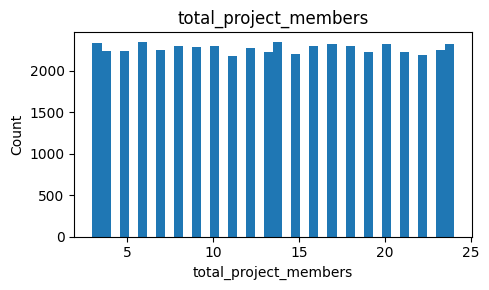

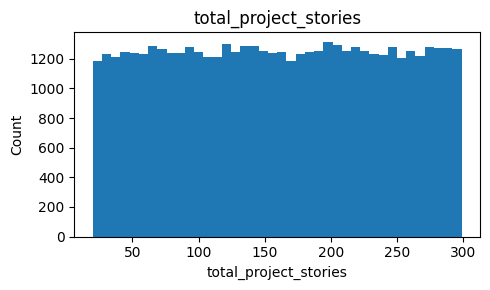

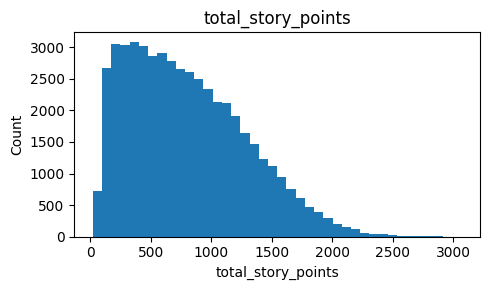

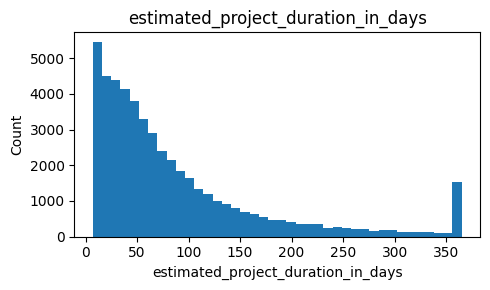

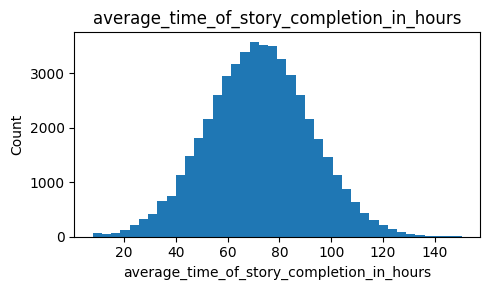

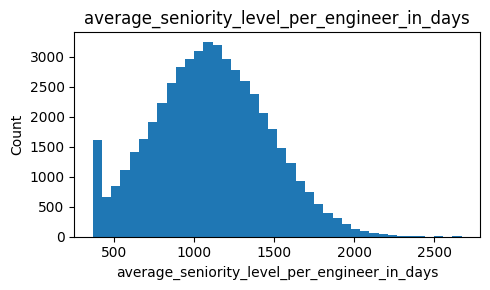

In [32]:
import matplotlib.pyplot as plt

cols_to_plot = [
    "total_project_members",
    "total_project_stories",
    "total_story_points",
    "estimated_project_duration_in_days",
    "average_time_of_story_completion_in_hours",
    "average_seniority_level_per_engineer_in_days",
]

for col in cols_to_plot:
    plt.figure(figsize=(5, 3))
    plt.hist(df_synth[col], bins=40)
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()


In [33]:
output_path = "jira_synthetic_projects.csv"
df_synth.to_csv(output_path, index=False)
print(f"Saved synthetic data to: {output_path}")

print("\nFinal label proportions:")
print(df_synth["is_delayed"].value_counts(normalize=True).rename("proportion"))


Saved synthetic data to: jira_synthetic_projects.csv

Final label proportions:
is_delayed
0    0.65344
1    0.34656
Name: proportion, dtype: float64


In [34]:
# Correlation of numeric features with is_delayed
corr_with_label = df_synth.corr(numeric_only=True)["is_delayed"].sort_values(ascending=False)
print(corr_with_label)


is_delayed                                      1.000000
average_time_of_story_completion_in_hours       0.476371
number_of_testing_stories                       0.447613
average_time_of_stories_in_progress_in_hours    0.445061
total_story_points                              0.416825
average_story_points_per_engineer               0.410686
estimated_project_duration_in_days              0.404222
total_project_stories                           0.341711
number_of_medium_priority_stories               0.258809
average_story_points_per_epic                   0.248911
number_of_stories_completed                     0.247066
number_of_stories_in_progress                   0.221892
number_of_low_priority_stories                  0.217564
average_story_points                            0.209292
number_of_high_priority_stories                 0.190101
number_of_stories_todo                          0.184775
number_of_stories_in_review                     0.149992
number_of_epics                

In [35]:
# Split projects into delayed vs not delayed
df_delayed = df_synth[df_synth["is_delayed"] == 1]
df_ontime = df_synth[df_synth["is_delayed"] == 0]

cols_to_compare = [
    "total_story_points",
    "number_of_testing_stories",
    "total_project_members",
    "average_seniority_level_per_engineer_in_days",
    "average_time_of_story_completion_in_hours",
    "average_time_of_stories_in_progress_in_hours",
]

print("=== Mean values by outcome ===")
summary = pd.DataFrame({
    "on_time_mean": df_ontime[cols_to_compare].mean(),
    "delayed_mean": df_delayed[cols_to_compare].mean(),
})
print(summary)


=== Mean values by outcome ===
                                              on_time_mean  delayed_mean
total_story_points                              651.524363   1076.416263
number_of_testing_stories                        31.762824     55.706775
total_project_members                            14.670941     11.255829
average_seniority_level_per_engineer_in_days   1149.819151   1003.844930
average_time_of_story_completion_in_hours        65.244338     85.217725
average_time_of_stories_in_progress_in_hours     34.721108     49.121816
